In [1]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [2]:
!pip install --quiet tensorflow

In [16]:
import pandas as pd
import csv

In [22]:
df = pd.read_csv('/content/sample_data/IMDB Dataset.csv')
texts  = df['review'].values
labels = (df['sentiment'] == 'positive').astype(int).values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

In [24]:
max_words = 20000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [25]:
def build_lstm():
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(max_words, 128)(inp)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [26]:
def build_transformer(num_heads=4, ff_dim=128):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(max_words, 64)(inp)
    positions = tf.range(start=0, limit=max_len, delta=1)
    pos_encoding = layers.Embedding(input_dim=max_len, output_dim=64)(positions)
    x = x + pos_encoding

    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=64)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
    ff = layers.Dense(ff_dim, activation='relu')(x)
    ff_output = layers.Dense(64)(ff)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [29]:
results = {}
for name, build_fn in [('LSTM', build_lstm), ('Transformer', build_transformer)]:
    print(f'\n{name} model training:')
    model = build_fn()
    start = time.time()
    history = model.fit(
        X_train_pad, y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.1,
        verbose=1
    )
    train_time = time.time() - start

    loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
    results[name] = {'time_s': train_time, 'accuracy': acc}
    print(f'{name} — train time: {train_time:.1f}s, test accuracy: {acc:.4f}')


LSTM model training:
Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.6872 - loss: 0.5403 - val_accuracy: 0.8953 - val_loss: 0.2655
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9140 - loss: 0.2254 - val_accuracy: 0.8932 - val_loss: 0.2623
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9482 - loss: 0.1469 - val_accuracy: 0.8815 - val_loss: 0.3172
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9719 - loss: 0.0899 - val_accuracy: 0.8710 - val_loss: 0.3893
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9800 - loss: 0.0648 - val_accuracy: 0.8760 - val_loss: 0.4092
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9861 - loss: 0.0451 - val_accuracy: 0.8790 - val_loss: 0.4714
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9927 - loss: 0.0248 - val_accuracy: 0.8687 - val_loss: 0.5686
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9952 

In [30]:
print('\n===== Comparison =====')
for name, r in results.items():
    print(f"{name:<12}  Time: {r['time_s']:.1f}s   Accuracy: {r['accuracy']:.4f}")


===== Comparison =====
LSTM          Time: 86.2s   Accuracy: 0.8760
Transformer   Time: 86.8s   Accuracy: 0.8642


task 2

In [32]:
import matplotlib.pyplot as plt

In [33]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

In [35]:
tokens = ["I", "want", "to", "great", "remont", "in", "my", "apartment", "but", "it", 'is', "expensive"]
seq_len = len(tokens)
d_model = 8

In [36]:
np.random.seed(42)
X = np.random.rand(seq_len, d_model)

In [37]:
W_q = np.random.rand(d_model, d_model)
W_k = np.random.rand(d_model, d_model)
W_v = np.random.rand(d_model, d_model)

In [38]:
Q = X.dot(W_q)
K = X.dot(W_k)
V = X.dot(W_v)

In [39]:
scores = Q.dot(K.T) / np.sqrt(d_model)
attention_weights = softmax(scores)

In [64]:
output = attention_weights.dot(V)

NameError: name 'attention_weights' is not defined

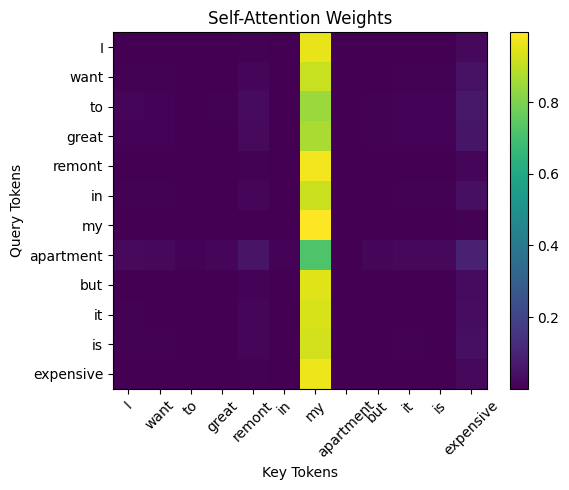

In [41]:
plt.figure(figsize=(6, 5))
plt.imshow(attention_weights, aspect='auto')
plt.colorbar()
plt.xticks(range(seq_len), tokens, rotation=45)
plt.yticks(range(seq_len), tokens)
plt.title("Self-Attention Weights")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.tight_layout()
plt.show()

In [42]:
print("Self-Attention output shape:", output.shape)
print(output)

Self-Attention output shape: (12, 8)
[[4.86039219 3.94443854 3.4546216  2.1014232  3.10769309 3.07389383
  2.7854282  3.81725212]
 [4.77329343 3.87846127 3.38644931 2.08122079 3.07092332 3.01342636
  2.74792093 3.73969534]
 [4.66838652 3.79861308 3.30413686 2.05650798 3.02434191 2.93925595
  2.70260323 3.6468629 ]
 [4.70418067 3.82591442 3.33231554 2.06492743 3.04024755 2.96478662
  2.71809128 3.67857826]
 [4.88086501 3.96002969 3.4700064  2.10577504 3.11453844 3.08780827
  2.79328027 3.83529097]
 [4.78348887 3.88614321 3.39481481 2.08401211 3.07634423 3.02039485
  2.75317914 3.74901245]
 [4.90660244 3.97941256 3.48937773 2.11095875 3.12277282 3.10519027
  2.80288081 3.85796091]
 [4.44957971 3.63177795 3.12968612 2.00159565 2.91745389 2.78344156
  2.60232963 3.45261107]
 [4.83635111 3.926228   3.43638188 2.09624978 3.09899283 3.05747653
  2.77601057 3.79611398]
 [4.81576431 3.91087652 3.41943857 2.09136562 3.08856061 3.04267846
  2.76635748 3.77753626]
 [4.80166167 3.8998496  3.4097132

Task 3

In [43]:
df = pd.read_csv('/content/sample_data/IMDB Dataset.csv')
texts  = df['review'].values
labels = (df['sentiment'] == 'positive').astype(int).values

In [48]:
def make_model():
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab_size, 64)(inp)
    positions = tf.range(start=0, limit=maxlen, delta=1)
    pos_emb = layers.Embedding(maxlen, 64)(positions)
    x = x + pos_emb

    x = layers.MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inp, out)

In [46]:
vocab_size = 8000
maxlen = 200
tok = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
tok.fit_on_texts(texts)
seqs = tok.texts_to_sequences(texts)
X = pad_sequences(seqs, maxlen=maxlen, padding='post')
y = labels

In [47]:
split = int(len(X)*0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [49]:
model = make_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [51]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9361 - loss: 0.1540 - val_accuracy: 0.8753 - val_loss: 0.3463
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9381 - loss: 0.1317 - val_accuracy: 0.8733 - val_loss: 0.4080
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9450 - loss: 0.1105 - val_accuracy: 0.8692 - val_loss: 0.4115
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9527 - loss: 0.0994 - val_accuracy: 0.8663 - val_loss: 0.4552
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9626 - loss: 0.0851 - val_accuracy: 0.8603 - val_loss: 0.5022
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9698 - loss: 0.0719 - val_accuracy: 0.8462 - val_loss: 0.5457
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9750 - loss: 0.0629 - val_accuracy: 0.8642 - val_loss: 0.5791
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9807 - loss: 0.0505 - val_accuracy: 0.

Task 4

In [50]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

train_path = "/content/t8.shakespeare.txt"
dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_path,
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

trainer.train()

from transformers import pipeline
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
print(generator("To be or not to be", max_length=50, num_return_sequences=1))


/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aisulu-aruzhan-kt (aisulu-aruzhan-kt-erreeer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,3.232000
1000,3.015800
1500,2.937700
2000,2.915500
2500,2.847400
3000,2.874300
3500,2.837200


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "To be or not to be, and so we'll walk along\n    To-night.\n\n                      Enter SERVANET, in his"}]


In [51]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

input_text = "translate English to French: I love machine learning"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
output = model.generate(input_ids)
print(tokenizer.decode(output[0], skip_special_tokens=True))

text = "summarize: The US has reported a record number of COVID-19 cases today as the virus continues to spread rapidly across states."
input_ids = tokenizer(text, return_tensors="pt").input_ids
summary = model.generate(input_ids, max_length=40)
print(tokenizer.decode(summary[0], skip_special_tokens=True))


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Je suis en amour de l'apprentissage de la machine
the virus continues to spread across states. the u.s. has reported a record number of cases today.


In [63]:
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import numpy as np
import evaluate
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/sample_data/IMDB Dataset.csv')
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
train_df, test_df = train_test_split(
    df[['review','label']],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

train_ds = Dataset.from_pandas(train_df)
test_ds  = Dataset.from_pandas(test_df)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model     = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

def tokenize_batch(batch):
    return tokenizer(batch['review'], padding='max_length', truncation=True, max_length=256)

train_tok = train_ds.map(tokenize_batch, batched=True)
test_tok  = test_ds.map(tokenize_batch, batched=True)

train_tok = train_tok.remove_columns(['review', '__index_level_0__'])
test_tok  = test_tok.remove_columns(['review', '__index_level_0__'])

train_tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])
test_tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])

accuracy  = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall    = evaluate.load('recall')
f1        = evaluate.load('f1')

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
        'accuracy':  accuracy.compute(predictions=preds, references=p.label_ids)['accuracy'],
        'precision': precision.compute(predictions=preds, references=p.label_ids)['precision'],
        'recall':    recall.compute(predictions=preds, references=p.label_ids)['recall'],
        'f1':        f1.compute(predictions=preds, references=p.label_ids)['f1'],
    }


from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir               = '/content/bert-imdb',
    num_train_epochs         = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    learning_rate            = 2e-5,
    weight_decay             = 0.01,
    logging_steps            = 50,
    eval_strategy            = 'epoch',
    save_strategy            = 'epoch',
)



trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_tok,
    eval_dataset    = test_tok,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
print("Evaluation metrics:", metrics)
trainer.save_model("/content/bert-imdb-final")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

<ipython-input-63-786008ebf721>:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.205100,0.218948,0.922200,0.899206,0.951000,0.924378
2,0.167300,0.240252,0.927400,0.940982,0.912000,0.926264
3,0.069900,0.301206,0.932000,0.927384,0.937400,0.932365


Evaluation metrics: {'eval_loss': 0.3012056052684784, 'eval_accuracy': 0.932, 'eval_precision': 0.9273842500989316, 'eval_recall': 0.9374, 'eval_f1': 0.9323652277700418, 'eval_runtime': 126.7119, 'eval_samples_per_second': 78.919, 'eval_steps_per_second': 4.932, 'epoch': 3.0}
